Using Colab cache for faster access to the 'data-science-bowl-2018-competition-merged-mask' dataset.
['data science bowl 2018']
Train path: /kaggle/input/data-science-bowl-2018-competition-merged-mask/data science bowl 2018/stage1_train 2


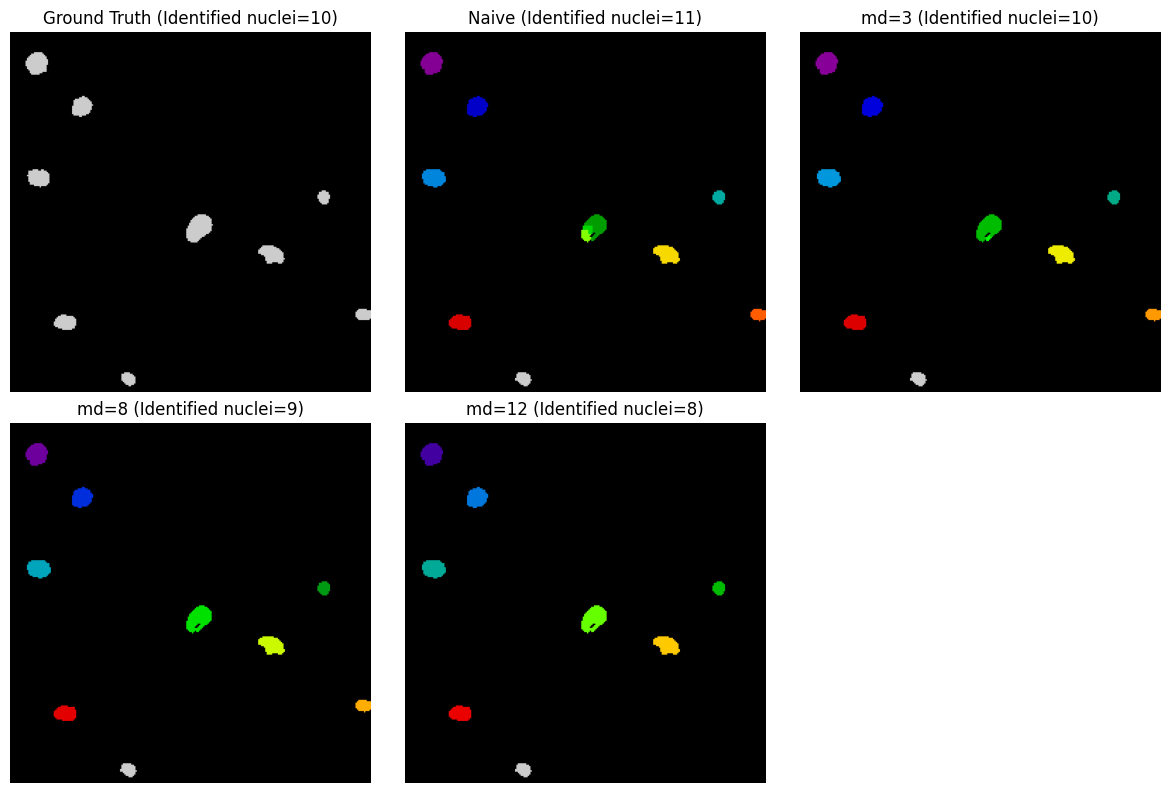

In [2]:
!pip install -q kagglehub

import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu

# -------- Download Dataset --------
dataset_path = kagglehub.dataset_download(
    "mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask"
)

print(os.listdir(dataset_path))

train_path = os.path.join(dataset_path, "data science bowl 2018/stage1_train 2")
print("Train path:", train_path)

sample_ids = os.listdir(train_path)

# -------- Pick One Sample --------
sample_id = sample_ids[0]
sample_path = os.path.join(train_path, sample_id)

image_folder = os.path.join(sample_path, "images")
mask_folder = os.path.join(sample_path, "masks")

image_file = os.listdir(image_folder)[0]
image = cv2.imread(os.path.join(image_folder, image_file))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# -------- Merge Instance Masks --------
mask_files = os.listdir(mask_folder)
merged = np.zeros_like(gray)

for m in mask_files:
    single_mask = cv2.imread(os.path.join(mask_folder, m), 0)
    merged = np.maximum(merged, single_mask)

merged = merged > 0
gt_count = len(mask_files)

# -------- Threshold --------
thresh = threshold_otsu(gray)
binary = gray > thresh
binary = remove_small_objects(binary, min_size=50)

# -------- Distance Transform --------
distance = ndi.distance_transform_edt(binary)

# -------- NAIVE WATERSHED --------
labels_naive = watershed(-distance, mask=binary)

# -------- MARKER CONTROLLED --------
min_distances = [3, 8, 12]
results = {}

for md in min_distances:
    coords = peak_local_max(distance, min_distance=md, labels=binary)

    marker_mask = np.zeros(distance.shape, dtype=bool)
    if len(coords) > 0:
        marker_mask[tuple(coords.T)] = True

    markers, _ = ndi.label(marker_mask)

    labels_md = watershed(-distance, markers, mask=binary)
    results[md] = labels_md

# -------- Visualization --------
plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.title("Ground Truth (Identified nuclei=" + str(gt_count) + ")")
plt.imshow(merged.astype(int), cmap='nipy_spectral')
plt.axis("off")

plt.subplot(2,3,2)
plt.title("Naive (Identified nuclei=" + str(labels_naive.max()) + ")")
plt.imshow(labels_naive, cmap='nipy_spectral')
plt.axis("off")

plt.subplot(2,3,3)
plt.title("md=3 (Identified nuclei=" + str(results[3].max()) + ")")
plt.imshow(results[3], cmap='nipy_spectral')
plt.axis("off")

plt.subplot(2,3,4)
plt.title("md=8 (Identified nuclei=" + str(results[8].max()) + ")")
plt.imshow(results[8], cmap='nipy_spectral')
plt.axis("off")

plt.subplot(2,3,5)
plt.title("md=12 (Identified nuclei=" + str(results[12].max()) + ")")
plt.imshow(results[12], cmap='nipy_spectral')
plt.axis("off")

plt.tight_layout()
plt.show()
